### ExamineAgeMenopause
##### E Flynn
##### 7/2/2018

The goal of this notebook is to bin the data by age, and then also into pre-post menopause, and examine these differences. 

Then, we will set up the phenotype definition for females and menopause:
* Pre-menopause: stated they have not reached menopause -AND- are less than 60 years old
* Post-menopause: >2 years post menopause -AND- had menopause after age 40

Others:
* Peri-menopause: w/in 2y menopause
* Premature_menopause: menopause less than age 40
* Unlikely_pre: greater than 60y and says that not reached menopause
* Missing: prefer not to answer or missing

In [1]:
require('tidyverse')

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.1     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
#target_dir <- '/oak/stanford/groups/mrivas/ukbb/24983/'
#covar_file <- 'phe_qc/ukb24983_GWAS_covar.phe'


COVARIATE_MATRIX <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/ukb24983_GWAS_covar.phe'
cov_mat <- read.table(COVARIATE_MATRIX, header=TRUE, stringsAsFactors=FALSE)
covar_data <- cov_mat[,c("IID","age", "sex")]

#covar_data <- read.table(sprintf("%s/%s", target_dir, covar_file), header=TRUE, stringsAsFactors=FALSE)

In [3]:
menopause_bin <- read.table("../phefiles/ss/BIN_FC1002724.phe")
menopause_age <- read.table("../phefiles/ss/INI3581.phe")

In [4]:
colnames(menopause_bin) <- c("ID", "ID2", "val")
colnames(menopause_age) <- c("ID", "ID2", "val")

menopause_bin$val[menopause_bin$val==-9] <- NA
menopause_age$val[menopause_age$val==-9] <- NA

meno_combined <- full_join(select(menopause_bin, -ID2), select(menopause_age, -ID2),by="ID", suffix=c(".bin", ".age"))
colnames(meno_combined) <- c("IID", "meno", "meno.age") # rename the menoapuse columns

head(meno_combined)


IID,meno,meno.age
1000010,NA,NA
1000028,1,NA
1000034,NA,NA
1000045,2,54
1000052,2,NA
1000069,2,50


In [5]:
combined_age_dat <- left_join(meno_combined,select(covar_data, c(IID, age, sex)), by="IID" ) # combine the data frames

combined_age_dat <- mutate(combined_age_dat, years.post=ifelse(meno.age<0, NA, age - meno.age)) # compute the years since menopause
combined_age_dat <- mutate(combined_age_dat, meno=(meno!=1)) # convert the menopause coding to TRUE and FALSE

In [6]:
head(combined_age_dat)

IID,meno,meno.age,age,sex,years.post
1000010,NA,NA,NA,NA,NA
1000028,FALSE,NA,54,0,NA
1000034,NA,NA,68,1,NA
1000045,TRUE,54,79,0,25
1000052,TRUE,NA,72,0,NA
1000069,TRUE,50,75,0,25


In [7]:
table(meno_combined$meno)
table(combined_age_dat$meno)


     1      2 
 60725 170356 


 FALSE   TRUE 
 60725 170356 

In [8]:
# make sure there are no males!
table(combined_age_dat[,c("sex", "meno")]) # hmmm what is going on with these 28 males? are they trans folks and does UKB stink at this?

   meno
sex  FALSE   TRUE
  0  58794 165143
  1     16     28

In [9]:
# menopause derived phenotypes?

label_col <- function(meno, meno.age, age, sex, years.post){
(if (sex==1 & !is.na(sex)){
        "male"
} else if (any(sapply(c(meno, age, sex), is.na))){
    "missing"
} else if (!meno){
    ifelse(age > 60, "unlikely", "pre")
} else {
    if (is.na(meno.age)) {
        "missing_age"
    } else{
           ifelse(meno.age <= 40, "premature",
           ifelse(years.post < 2 | is.na(years.post), "peri", "post")
          ) 
    }


})}
 


df <- combined_age_dat 
combined_age_dat2 <- combined_age_dat
combined_age_dat2$meno.label <- mapply(label_col, df$meno, df$meno.age, df$age, df$sex, df$years.post)



#if (meno.age >=40 & years.post >=2 & sex==0{})


#combined_age_dat2 <- mutate(combined_age_dat, 
#                            phe.label=ifelse(meno.age >= 40 & years.post >=2 & sex==0, 1,
#                                             ifelse(!meno & age <= 60, 0, NA)))


In [10]:
head(combined_age_dat2)
table(combined_age_dat2$meno.label)

IID,meno,meno.age,age,sex,years.post,meno.label
1000010,NA,NA,NA,NA,NA,missing
1000028,FALSE,NA,54,0,NA,pre
1000034,NA,NA,68,1,NA,male
1000045,TRUE,54,79,0,25,post
1000052,TRUE,NA,72,0,NA,missing_age
1000069,TRUE,50,75,0,25,post



       male     missing missing_age        peri        post         pre 
     223481       55125       10399         292      144693       53005 
  premature    unlikely 
       9759        5789 

In [42]:
write.table(combined_age_dat2, file="../data/menopause_age_data_pheno.txt", row.names=FALSE, quote=FALSE )

# MENSTRUAL PHASE

In [26]:
# NOTE - these questions are poorly worded and have strange cutoffs...

# time since last period: 3700 http://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=3700
# length of menstrual cycle: 3710
# menstruating today: 3720

# We may need to go back to original data

meno_today <- read.table("../phefiles/ss/BIN_FC10003720.phe")
meno_length <- read.table("../phefiles/ss/INI3710.phe")
meno_time <- read.table("../phefiles/ss/INI3700.phe")

colnames(meno_time) <- c("ID", "ID2", "day_in_cycle")
colnames(meno_length) <- c("ID", "ID2", "cycle_length")
colnames(meno_today) <- c("ID", "ID2", "meno_today")


In [27]:
length_time <- full_join(meno_time %>% select(-ID2), meno_length %>% select(-ID2), by="ID")
cycle_info <- full_join(length_time, meno_today %>% select(-ID2), by="ID")

In [30]:
head(cycle_info)
table(cycle_info$cycle_length==-9)
table(cycle_info$meno_today==-9)

table(cycle_info$day_in_cycle==-9)

cycle_present <- filter(cycle_info, cycle_length!=-9 & day_in_cycle!=-9 & meno_today !=-9)

ID,day_in_cycle,cycle_length,meno_today
4646215,-9,-9,-9
5007659,-9,-9,-9
1038854,24,24,1
5441319,-9,-9,-9
5743544,-9,-9,-9
3266897,-9,-9,-9



 FALSE   TRUE 
 48523 454020 


 FALSE   TRUE 
 75020 427523 


 FALSE   TRUE 
 56369 446174 

In [34]:
head(cycle_present)
table(cycle_present$meno_today) # 2 == yes, 1 == no

# HOWEVER - for a subset, we are fairly confident
# meno_length < 60 & meno_length > 14
range_filt <- cycle_present %>% filter(cycle_length <= 60 & cycle_length > 14)

ID,day_in_cycle,cycle_length,meno_today
1038854,24,24,1
5044418,22,29,1
5031984,9,35,1
1356470,10,30,1
1175053,21,28,1
1924613,21,28,1



    1     2 
36842  8687 

ID,day_in_cycle,cycle_length,meno_today
4039288,0,25,2
4501489,0,28,2
2423214,0,30,2
2295542,0,28,2
4007318,0,28,2
3710308,5,28,2


In [38]:
cycle_labeled <- range_filt %>% mutate(approx_ov = cycle_length/2) %>% 
mutate(phase=ifelse(meno_today==2, "menstrual", ifelse(day_in_cycle < approx_ov, "follicular", "luteal")))

In [40]:
head(cycle_labeled)
table(cycle_labeled$phase)
write.table(cycle_labeled, file="../data/menstrual_phase.txt", sep="\t", row.names=FALSE, quote=FALSE)

ID,day_in_cycle,cycle_length,meno_today,approx_ov,phase
1038854,24,24,1,12.0,luteal
5044418,22,29,1,14.5,luteal
5031984,9,35,1,17.5,follicular
1356470,10,30,1,15.0,follicular
1175053,21,28,1,14.0,luteal
1924613,21,28,1,14.0,luteal



follicular     luteal  menstrual 
     15395      20897       8512 

In [ ]:

# sanity check this
filter(range_filt, meno_today==2) %>% head()


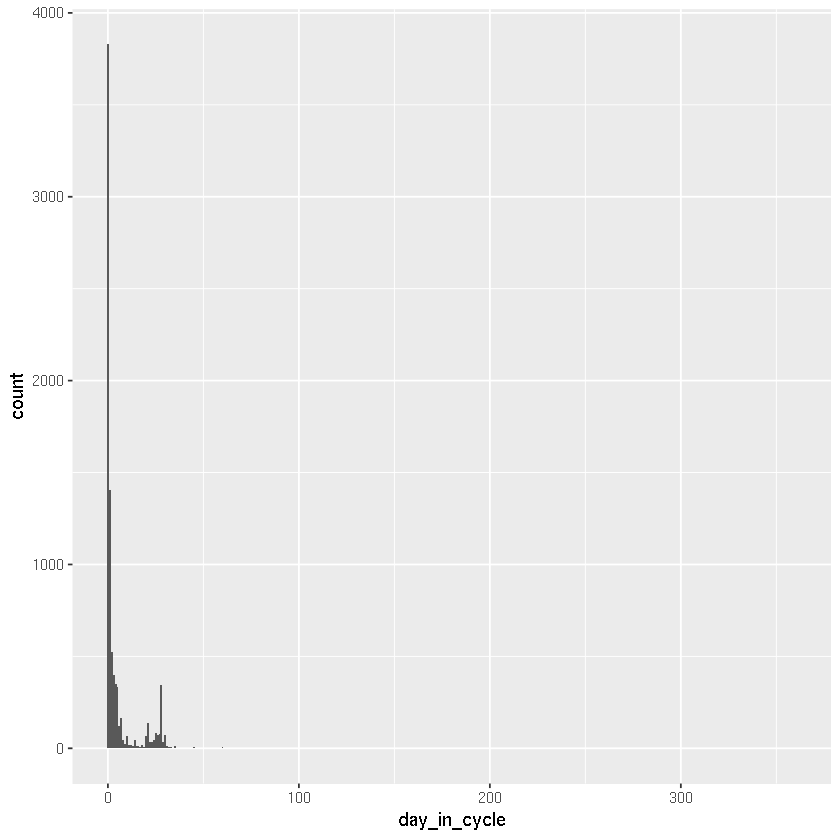

In [37]:
#meno_today and meno_time to validate - should be a distribution
ggplot(filter(range_filt, meno_today==2), aes(day_in_cycle))+geom_histogram(binwidth=1)
### disproportionately day 0! I think ppl are mis-interpreting, estimate this

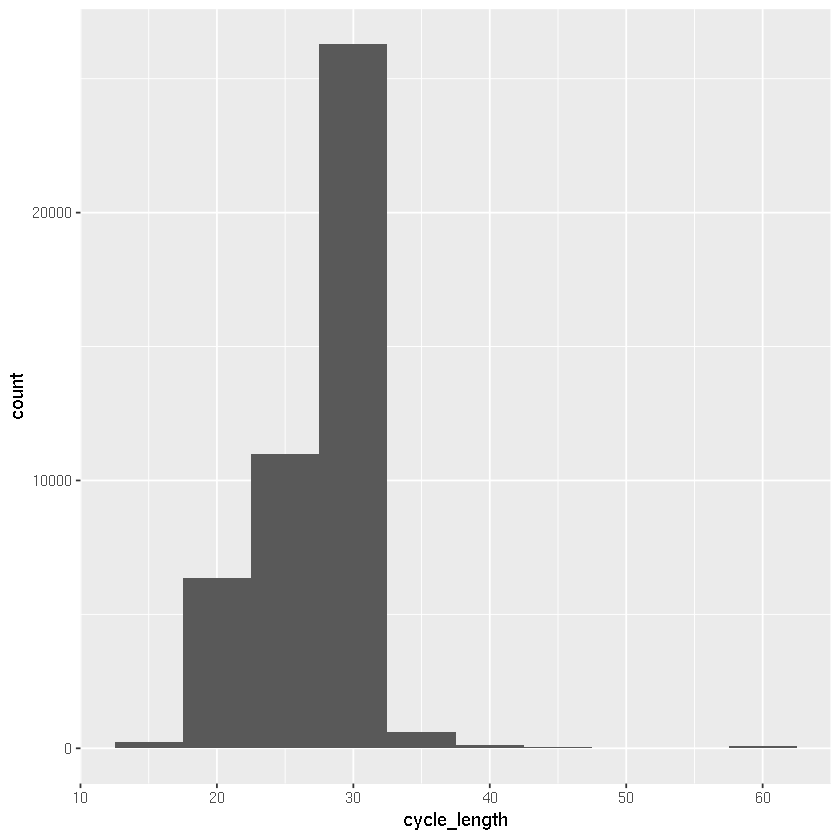

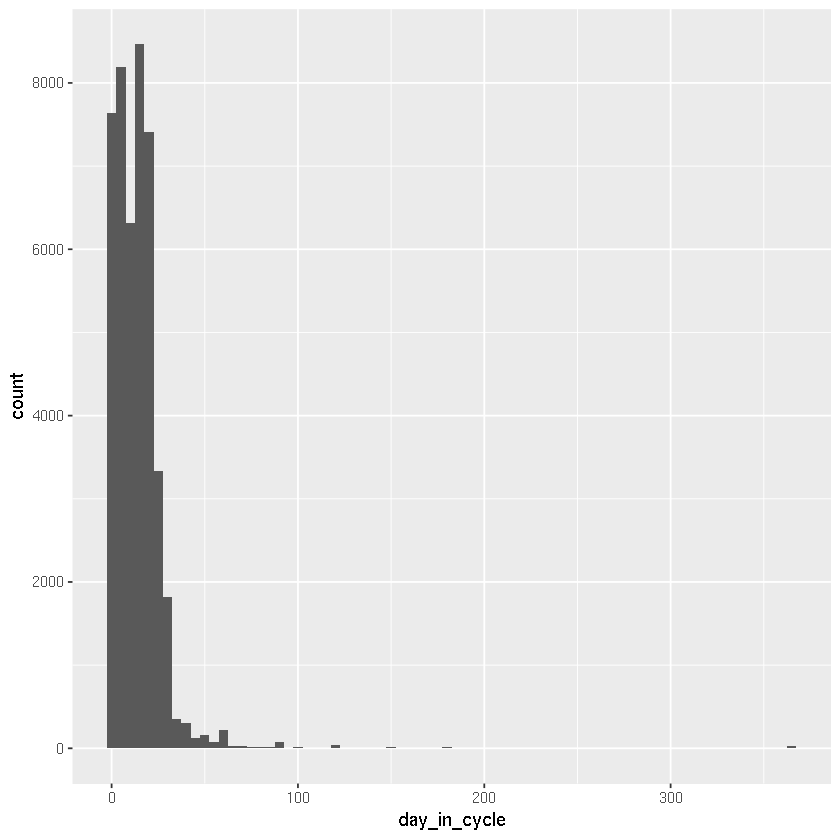

In [36]:
ggplot(range_filt, aes(cycle_length))+geom_histogram(binwidth=5)
ggplot(range_filt, aes(day_in_cycle))+geom_histogram(binwidth=5)

In [25]:
filter(meno_time, val < 0) %>% head()
filter(meno_length, val < 0) %>% head()
table(meno_today$val)

ID,ID2,val
4646215,4646215,-9
5007659,5007659,-9
5441319,5441319,-9
5743544,5743544,-9
3266897,3266897,-9
3990694,3990694,-9


ID,ID2,val
4646215,4646215,-9
5007659,5007659,-9
5441319,5441319,-9
5743544,5743544,-9
3266897,3266897,-9
3990694,3990694,-9



    -9      1      2 
427523  63468  11552 

Warning message:
“Removed 896 rows containing non-finite values (stat_bin).”Warning message:
“Removed 8 rows containing missing values (geom_bar).”

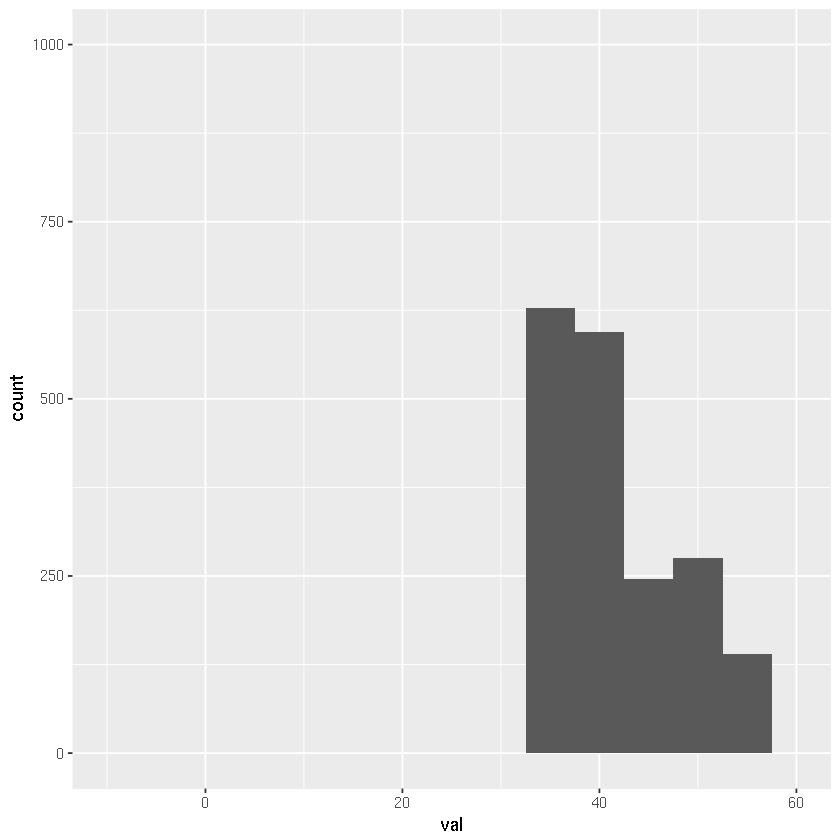

In [20]:
ggplot(meno_time, aes(val))+geom_histogram(binwidth=5)+xlim(-10, 60)+ylim(0, 1000)

# DEPRECATED

In [56]:
head(filter(combined_age_dat2, !meno))

IID,meno,meno.age,age,sex,years.post,meno.label
1000028,FALSE,NA,54,0,NA,pre
1000254,FALSE,NA,57,0,NA,pre
1000353,FALSE,NA,50,0,NA,pre
1000384,FALSE,NA,53,0,NA,pre
1000430,FALSE,NA,62,0,NA,unlikely
1000465,FALSE,NA,52,0,NA,pre


In [20]:
table(combined_age_dat2$phe.label)


     0      1 
     9 148196 

In [11]:
write.table(combined_age_dat, file="../data/menopause_age_data.txt", row.names=FALSE, quote=FALSE )

IID,meno,meno.age,age,sex,years.post
1000010,NA,NA,NA,NA,NA
1000028,FALSE,NA,54,0,NA
1000034,NA,NA,68,1,NA
1000045,TRUE,54,79,0,25
1000052,TRUE,NA,72,0,NA
1000069,TRUE,50,75,0,25


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


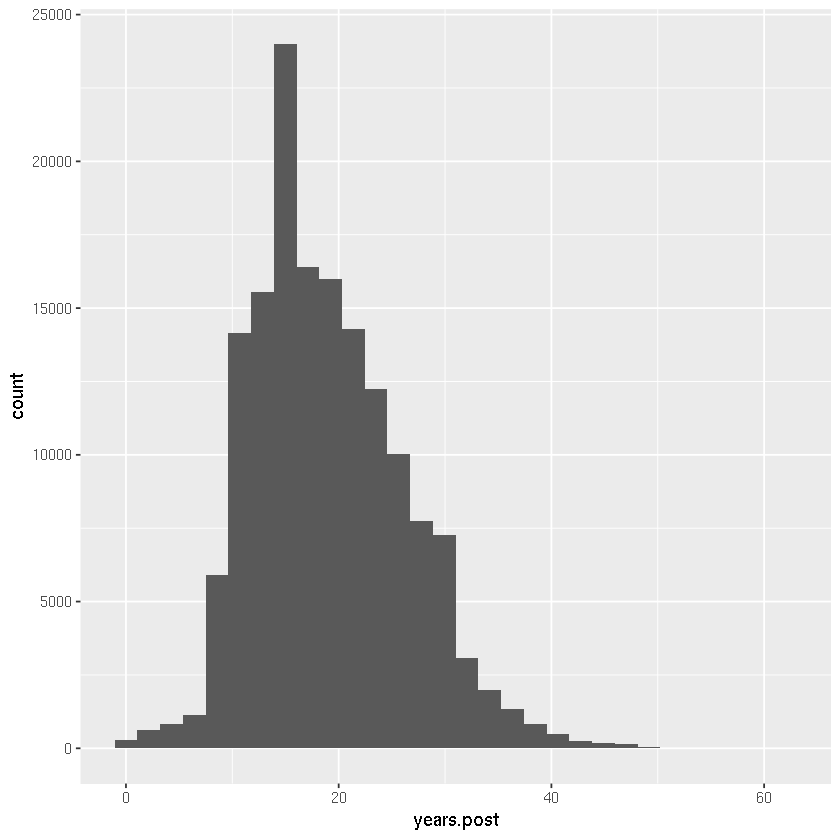

In [12]:
# separate people into post-menopause (>2years), peri-menopause (0-2years), pre-menopause
# -- reason to do this
# how many fall in each category?
head(combined_age_dat)
ggplot(data=combined_age_dat[!is.na(combined_age_dat$years.post),], aes(years.post)) +geom_histogram()

In [10]:

nrow(filter(combined_age_dat, years.post < 2 & !is.na(years.post))) # 15 

# premature menopause - occuring in a woman younger than 40 years
nrow(filter(combined_age_dat, meno.age < 40 & !is.na(years.post)))
nrow(filter(combined_age_dat, meno.age < 30 & !is.na(years.post)))

nrow(filter(combined_age_dat, meno.age >= 40 & years.post >=2 & !is.na(years.post))) # 145,812


[1] 15

[1] 6746

[1] 1201

[1] 145796

In [11]:
nrow(filter(combined_age_dat, !meno & age > 70))
nrow(filter(combined_age_dat, !meno & age <= 70))

# there are a lot of people over 65 who have not had menopause... this is surprising to me

[1] 579

[1] 59895

In [12]:
nrow(filter(combined_age_dat, !meno & is.na(age))) # some are missing age data

[1] 1988

In [13]:
# phenotype-label
# 1 = menopause, 0 = pre-menopause, NA = QC removed
combined_age_dat2 <- mutate(combined_age_dat, 
                            phe.label=ifelse(meno.age >= 40 & years.post >=2 & !is.na(years.post), 1,
                                             ifelse(!meno & age <= 70, 0, NA)))

table(combined_age_dat2$phe.label)


     0      1 
 59895 145796 

[1] 62462

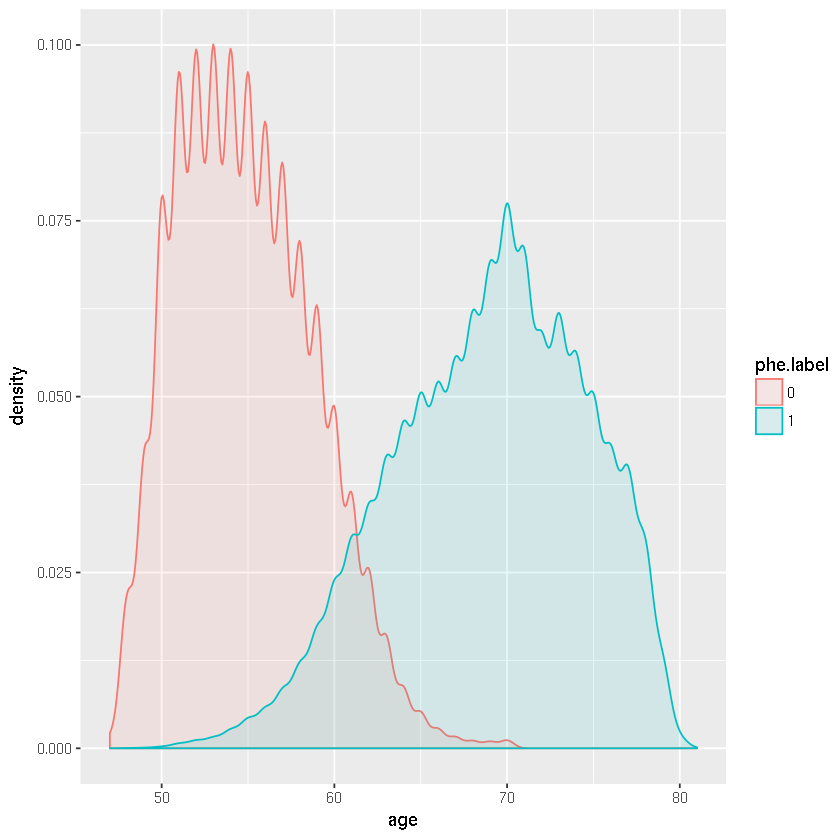

In [14]:
nrow(filter(combined_age_dat, !meno)) # 62,462

combined_age_dat3 <- combined_age_dat2[!is.na(combined_age_dat2$phe.label),]
combined_age_dat3$phe.label <- as.factor(combined_age_dat3$phe.label)
ggplot(data=combined_age_dat3, aes(age, colour=phe.label, fill=phe.label)) +geom_density(alpha=0.1)

# this really divides the group by age <-- although some of this is by definition


In [15]:
# write out the labels as phe files
pre_meno <- filter(combined_age_dat3, phe.label == 0 )
#write.table(select(pre_meno, IID), file="../phefiles/pre_meno.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
post_meno <- filter(combined_age_dat3, phe.label == 1 )
#write.table(select(post_meno, IID), file="../phefiles/post_meno.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)

# Qs to ask:
# - does age affect this?


In [22]:
# how do I have more females than I thought?
# - are we removing the appropriate samples?
onesex.tab <- read.table("../phefiles/old_sex_labels/onesex.keep") # 156k
nrow(onesex.tab)

zerosex.tab <- read.table("../phefiles/old_sex_labels/zerosex.keep") # 181k
nrow(zerosex.tab)

# - yet somehow I have 168+62 :/ 

# oh whoops - forgot to remove data 
removal_file_one <- '/oak/stanford/groups/mrivas/ukbb/24983/sqc/ukb24983_remove.phe'
removal_file_two <- '/oak/stanford/groups/mrivas/ukbb/24983/sqc/w2498_20170726.phe'
remove1 <- read.table(removal_file_one, header=FALSE)
remove2 <- read.table(removal_file_two, header=FALSE) # this file is messy b/c of meta characters - only has three people in it tho
ids.to.remove <- c(remove1[,1], unique(remove2[,1]))


[1] 156135

[1] 181064

In [30]:
head(ids.to.remove)
pre_meno2 <- pre_meno[!(pre_meno$IID %in% ids.to.remove),] # 38,945
(num.pre <- nrow(pre_meno2))
post_meno2 <- post_meno[!(post_meno$IID %in% ids.to.remove),] # 101,586
(num.post <- nrow(post_meno2))

# ok this is more reasonable

# re-write the files
write.table(select(pre_meno2, IID), file="../phefiles/pre_meno.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(select(post_meno2, IID), file="../phefiles/post_meno.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)


[1] 2652670 2850227 3946352 3073546 2063443 4144793

[1] 38945

[1] 101586

In [35]:
# down-sample
# - does the label imbalance affect things?

# what if we downsample post_meno to 38k? (is this too small)

# also downsample males

set.seed(724)
keep_rows_post <- sample(1:num.post, num.pre, replace=FALSE)
onesex.tab <- read.table("../phefiles/old_sex_labels/onesex.keep") # 156k
colnames(onesex.tab) <- "IID"
num.m <- nrow(onesex.tab)
keep_rows_male <- sample(1:num.m, num.pre, replace=FALSE)
post_meno_down <- post_meno2[keep_rows_post,]
onesex_down <- onesex.tab[keep_rows_male,]

# write these out
write.table(select(pre_meno2, IID), file="../pr")
write.table(select(post_meno_down, IID), file="../phefiles/post_meno_d.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
#write.table(select(onesex_down, IID), file="../phefiles/onesex_d.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(onesex_down, file="../phefiles/onesex_d.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)

In [48]:
# age-divide the data
# at what cut-point? we could do over + under 65

head(covar_data[,1:5])
covar_data_keep <- covar_data[!(covar_data$IID %in% ids.to.remove),]
covar_data_keep %>% group_by(sex) %>% summarize(median(age)) # mean age is ~65

table(covar_data_keep[covar_data_keep$age < 50,]$sex) # only 2k in each --> POOR CHOICE

FID,IID,age,sex,Array
2502845,2502845,50,1,1
2314965,2314965,55,0,1
1142584,1142584,60,0,1
3665122,3665122,74,0,1
4377492,4377492,65,0,1
2652670,2652670,58,1,1


sex,median(age)
0,67
1,68



   0    1 
2207 1990 

In [49]:
over65.f <- covar_data_keep$IID[covar_data_keep$age > 65 & covar_data_keep$sex == 0]
over65.m <- covar_data_keep$IID[covar_data_keep$age > 65 & covar_data_keep$sex == 1]
under65.f <- covar_data_keep$IID[covar_data_keep$age <= 65 & covar_data_keep$sex == 0]
under65.m <- covar_data_keep$IID[covar_data_keep$age <= 65 & covar_data_keep$sex == 1]

In [53]:
length(over65.f) # 99571
length(over65.m) # 90319
length(under65.f) # 81496
length(under65.m) # 65820 -- huh this is less!

# for now - just run with all
# next time --> we will try downsampling

write.table(over65.f, file="../phefiles/over65_f.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(over65.m, file="../phefiles/over65_m.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(under65.f, file="../phefiles/under65_f.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(under65.m, file="../phefiles/under65_m.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)

[1] 99571

[1] 90319

[1] 81496

[1] 65820